# 🧹 Cleaning Eye-Tracking Data and Output Descriptive Summary

This notebook loads, filters, and saves cleaned eye-tracking data for further analysis.

In [32]:
from datetime import datetime

print("📅 Last updated:", datetime.now().strftime("%Y-%m-%d %H:%M"))


📅 Last updated: 2025-07-03 19:50


In [2]:
# Import packages
import pandas as pd

# Load raw data
df = pd.read_csv("../data/raw/eye_tracking_2025.csv")
df.head()
print(f"All trials: {len(df)}")

All trials: 1679


In [3]:
# Drop test trails, where any of the key fields are 'UNDEFINED'
undefined_mask = (
    (df['Session_Name_'] == 'UNDEFINED') |
    (df['Trial_Index_'] == 'UNDEFINED') |
    (df['result'] == 'UNDEFINED') |
    (df['trialid'] == 'UNDEFINED')
)

df = df[~undefined_mask]

print(f"✅ Remaining rows after dropping UNDEFINED trials: {len(df)}")


✅ Remaining rows after dropping UNDEFINED trials: 1582


In [21]:
# Merge Eye-Tracking Data with Answer Keys

# Load key file
df_key = pd.read_excel("../data/raw/Eyetracking_OA_key_0926.xlsx")

# Ensure both trailid variables in two datasets are strings
df['trialid'] = df['trialid'].astype(str)
df_key['trialid'] = df_key['trialid'].astype(str)


# === Merge Data ===
df_rated = df.merge(df_key[["trialid", "key"]], on="trialid", how="left")

# === Summary ===
print("Merge complete.")
print(f"Original data rows: {len(df)}")
print(f"Merged data rows: {len(df_rated)}")
print(f"Missing keys after merge: {df_rated['key'].isna().sum()}")

# Preview result
df_rated.head()


Merge complete.
Original data rows: 1582
Merged data rows: 1582
Missing keys after merge: 0


,RECORDING_SESSION_LABEL,INDEX,AVERAGE_BLINK_DURATION,AVERAGE_FIXATION_DURATION,AVERAGE_SACCADE_AMPLITUDE,AVERAGE_X_RESOLUTION,AVERAGE_Y_RESOLUTION,BLINK_COUNT,BUTTON_PRESS_COUNT,BUTTON_RELEASE_COUNT,...,SD_FIXATION_DURATION,SD_SACCADE_AMPLITUDE,START_TIME,TRIAL_LABEL,VISITED_INTEREST_AREA_COUNT,Session_Name_,Trial_Index_,result,trialid,key
0,ET24_066,2,140,366.88,5.45,56.87,57.27,3,0,0,...,198.33,4.69,92190160,Trial: 2,6,ET24_066,1,choice5,4,5
1,ET24_066,3,178,354.98,5.54,56.73,57.10,5,0,0,...,206.06,5.23,92216758,Trial: 3,6,ET24_066,2,choice1,12,1
2,ET24_066,4,5788,.,12.28,59.00,57.80,1,0,0,...,.,0,92242664,Trial: 4,0,ET24_066,3,choice3,1,3
3,ET24_066,5,13560,.,12.4,58.40,57.50,1,0,0,...,.,0,92250758,Trial: 5,0,ET24_066,4,choice3,18,1
4,ET24_066,6,7765,206.57,8.63,53.41,53.66,2,0,0,...,142.05,5.75,92266772,Trial: 6,5,ET24_066,5,choice3,6,3


# Rate Response

In [22]:
# Extract numeric part from 'result'
df_rated['response_num'] = df_rated['result'].str.extract(r'(\d+)').astype(float)

# Compare with key to determine correctness
df_rated['response'] = (df_rated['response_num'] == df_rated['key']).astype(int)

# Save rated csv
df_rated.to_csv("../data/eye_tracking_rated.csv", index=False)

# Preview results
df_rated[['Session_Name_', 'Trial_Index_', 'result', 'key', 'response']].head()


,Session_Name_,Trial_Index_,result,key,response
0,ET24_066,1,choice5,5,1
1,ET24_066,2,choice1,1,1
2,ET24_066,3,choice3,3,1
3,ET24_066,4,choice3,1,0
4,ET24_066,5,choice3,3,1


# Participant Performance Summary

In [23]:
# Group by participant/session and calculate mean accuracy
summary = df_rated.groupby('Session_Name_')['response'].agg(
    accuracy='mean',
    total_trials='count',
    correct_trials='sum'
).reset_index()

# Convert accuracy to percentage
summary['accuracy_percent'] = (summary['accuracy'] * 100).round(2)

# Preview
summary.sort_values(by='accuracy_percent', ascending=False)


,Session_Name_,accuracy,total_trials,correct_trials,accuracy_percent
36,ET220054,0.75,20,15,75.0
22,ET220034,0.70,20,14,70.0
71,ET24_092,0.70,20,14,70.0
16,ET220018,0.65,20,13,65.0
75,ET24_096,0.65,20,13,65.0
...,...,...,...,...,...
53,ET24_072,0.30,20,6,30.0
67,ET24_088,0.30,20,6,30.0
57,ET24_076,0.30,20,6,30.0
32,ET220047,0.25,20,5,25.0


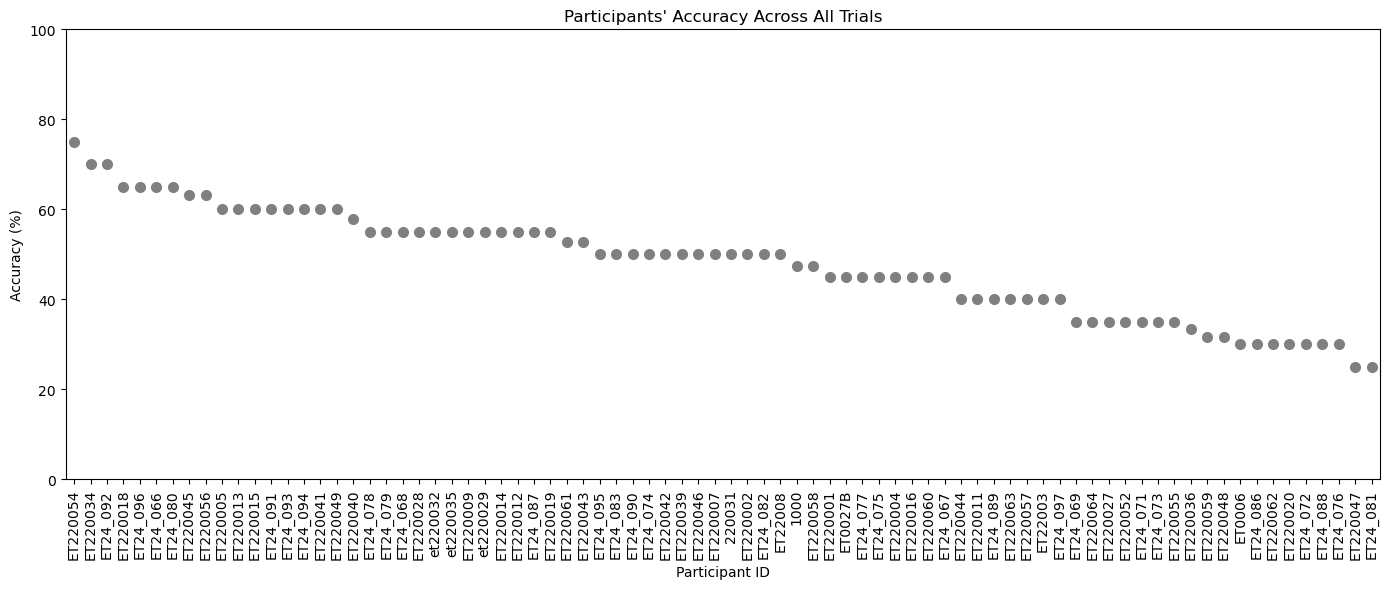

In [30]:
import matplotlib.pyplot as plt
import seaborn as sns

# Sort for better visualization
summary_sorted = summary.sort_values(by='accuracy_percent', ascending=False)

# Plot
plt.figure(figsize=(14, 6))
sns.stripplot(x='Session_Name_', y='accuracy_percent', data=summary_sorted, color='gray', size=8)

plt.ylabel('Accuracy (%)')
plt.xlabel('Participant ID')
plt.title("Participants' Accuracy Across All Trials")
plt.xticks(rotation=90)
plt.ylim(0, 100)
plt.tight_layout()
plt.show()


# Item Descriptive Summary

In [28]:
# Group by trialid and evaluate item-level performance
item_summary = df_rated.groupby('trialid')['response'].agg(
    accuracy='mean',
    total_responses='count',
    correct_responses='sum'
).reset_index()

# Add accuracy percentage
item_summary['accuracy_percent'] = (item_summary['accuracy'] * 100).round(2)

# Optional: sort by difficulty (easiest to hardest)
item_summary = item_summary.sort_values(by='accuracy')

# Preview
item_summary.head()


,trialid,accuracy,total_responses,correct_responses,accuracy_percent
12,20,0.025641,78,2,2.56
17,7,0.037975,79,3,3.80
8,17,0.063291,79,5,6.33
5,14,0.125000,80,10,12.50
4,13,0.150000,80,12,15.00


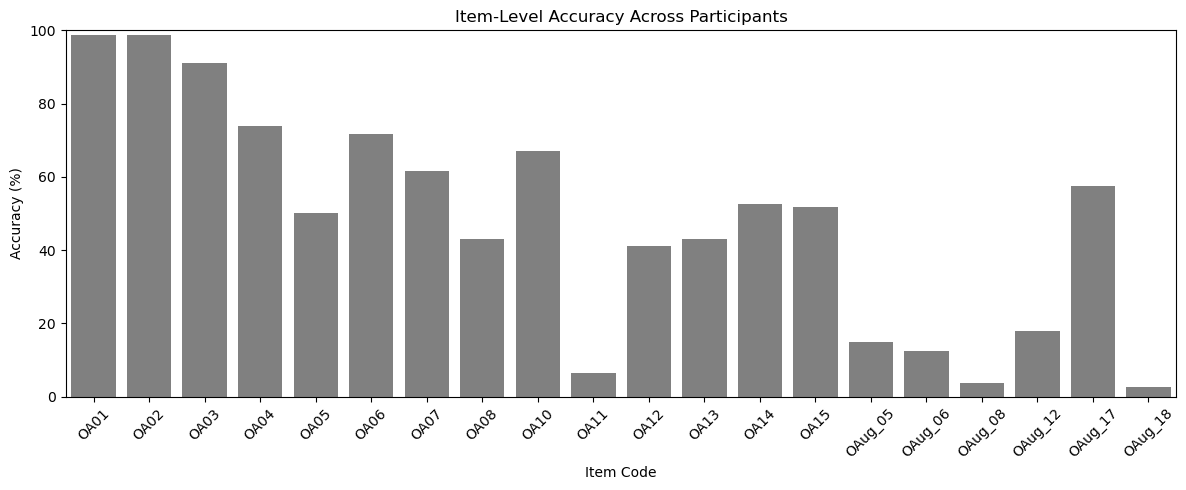

In [27]:
import matplotlib.pyplot as plt
import seaborn as sns

# Merge item codes for clearer x-axis labels
df_key['trialid'] = df_key['trialid'].astype(str)
item_summary['trialid'] = item_summary['trialid'].astype(str)
item_plot_data = item_summary.merge(df_key[['trialid', 'Item']], on='trialid', how='left')

# Sort by item label
item_plot_data = item_plot_data.sort_values(by='Item')

# Plot
plt.figure(figsize=(12, 5))
sns.barplot(x='Item', y='accuracy_percent', data=item_plot_data, color='gray')

plt.ylabel('Accuracy (%)')
plt.xlabel('Item Code')
plt.title('Item-Level Accuracy Across Participants')
plt.xticks(rotation=45)
plt.ylim(0, 100)
plt.tight_layout()
plt.show()
